In [1]:
import pickle
data = pickle.load(open("data/data.plk", "rb"))

In [2]:
len(data)

4351

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords


wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
def get_lemmatized_words(sentence):
    _temp = []
    tokens = nltk.word_tokenize(sentence)
    lmtzr = WordNetLemmatizer()
    
    for word, token in nltk.pos_tag(tokens):
        if word.strip().lower() not in stopwords.words('english') and word.strip().lower().isalnum() and len(word.strip().lower()) > 1:
            _temp.append(lmtzr.lemmatize(word.strip().lower(), get_wordnet_pos(token)))
    return _temp

In [14]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
from gensim import corpora,models, similarities

abstract_list = [get_lemmatized_words(x["název (anglicky)"]) for x in data if len(x["název (anglicky)"]) > 2 and len(x["katedra"]) > 1]
print(len (abstract_list))
# corpora.Dictionary(): Dictionary encapsulates the mapping between normalized words and their integer ids.
dictionary = corpora.Dictionary(abstract_list)
print(dictionary)

appear_once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

# filter_tokens(): Remove the selected bad_ids tokens from all dictionary mappings
dictionary.filter_tokens(appear_once_ids)

# compactify(): Assign new word ids to all words
dictionary.compactify()

print(dictionary)
    

4217
Dictionary(3651 unique tokens: ['emulation', 'introduction', 'jdbc', 'aproximation', 'possible']...)
Dictionary(1747 unique tokens: ['ctu', 'emulation', 'introduction', 'jdbc', 'department']...)


In [16]:
# doc2bow(): Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples
corpus = [dictionary.doc2bow(words) for words in abstract_list]

#corpora.mmcorpus.MmCorpus.serialize('data/shkspr.mm', corpus)

# TfidfModel(): word-document co-occurrence matrix (integers) into a locally/globally weighted TF_IDF matrix (positive floats)
tfidf = models.TfidfModel(corpus)

In [18]:
papers = [(" ".join(get_lemmatized_words(x["název (anglicky)"])), "FEL" if len(x["katedra"]) == 6 else "FIT"  ) for x in data if len(x["katedra"]) > 1]
universities = list(set(["FEL" if len(x["katedra"]) == 6 else "FIT" for x in data if len(x["katedra"]) > 1]))

In [20]:
papers[0]

('salzella declarative language music generation', 'FEL')

In [22]:
print ("FEL" , len([x for x in papers if x[1] == "FEL"]))
print ("FIT" , len([x for x in papers if x[1] == "FIT"]))

FEL 3478
FIT 851


In [21]:
# LsiModel():  Latent Semantic Analysis (aka Latent Semantic Indexing)

lsi = models.lsimodel.LsiModel(corpus=tfidf[corpus], id2word=dictionary,num_topics=len(universities),power_iters=50,onepass=False,chunksize=20)
for i, topic in enumerate(lsi.print_topics(len(universities))):
    print('Topic {}:'.format(i))
    print(topic[1].replace(' + ', "\n"))
    print('')

Topic 0:
0.586*"system"
0.476*"information"
0.288*"management"
0.254*"web"
0.183*"application"
0.160*"project"
0.124*"support"
0.112*"implementation"
0.106*"design"
0.095*"interface"

Topic 1:
0.488*"web"
0.434*"application"
-0.428*"information"
-0.355*"system"
0.196*"interface"
0.125*"tool"
0.125*"user"
0.118*"data"
0.103*"mobile"
0.087*"management"



In [24]:
# Calculate a similarity value between each tcc
matsim = similarities.MatrixSimilarity(lsi[tfidf[corpus]], num_best=6)

In [25]:
corpus[:2]

[[(199, 1), (290, 1), (983, 1), (1066, 1), (1615, 1)],
 [(398, 1), (472, 1), (901, 1), (953, 1), (1026, 1), (1163, 1)]]

In [26]:
lsi[tfidf[corpus[0]]]

[(0, 0.013141595061355505), (1, 0.02554211849474973)]

In [27]:
len(universities)

2

In [28]:
def format_topic_coeffs(topic):
    """Return a list of coefficent, word tuples with coefficent truncated to 
    3 decimal places.
    """
    return [(coeff, word) for coeff, word in topic]

def plot_axes(x=0, y=1, model=lsi, corpus=corpus, 
              tfidf=tfidf, papers=papers, universities=universities):
    x_data = defaultdict(list)
    y_data = defaultdict(list)
    chars = defaultdict(list)
    print('x topic:')
    print(format_topic_coeffs(model.show_topic(x)))
    print('')
    print('y topic:')
    print(format_topic_coeffs(model.show_topic(y)))
    for paper, doc in zip(papers, corpus):
        university = paper[1]
        if len(model[tfidf[doc]]) != 0:
            x_data[university].append((model[tfidf[doc]][x][1]))
            y_data[university].append((model[tfidf[doc]][y][1]))
            '''Remove the comment of the next line to show titles of each work'''
            #chars[university].append(paper[0])
    print("next")    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    cmap = plt.get_cmap('Paired')
    university_index = {university: i for i, university in enumerate(universities)}
    for university in university_index:
        color_index = university_index[university] / float(len(university_index))
        plt.scatter(x_data[university], y_data[university], color=cmap(color_index), 
                    label=university, alpha=.5, s=40)
        for char, x, y in zip(chars[university], x_data[university], y_data[university]):
            ax.annotate(char, xy=(x, y), xycoords='data', xytext=(1, 1), 
                        textcoords='offset points', size=10)
    plt.legend(loc=1, ncol=2, scatterpoints=1)
    plt.show()

x topic:
[('system', 0.58565627795271535), ('information', 0.47620989245592288), ('management', 0.28832298288639446), ('web', 0.25447308693416193), ('application', 0.18289542029380487), ('project', 0.15979190237210339), ('support', 0.12384189806268962), ('implementation', 0.11185479016696184), ('design', 0.10608730432486833), ('interface', 0.095378097849436821)]

y topic:
[('web', 0.48756491315473094), ('application', 0.43359596585136262), ('information', -0.42814681548921363), ('system', -0.35497662883909331), ('interface', 0.19626384181666451), ('tool', 0.12544500981748505), ('user', 0.12526416756102829), ('data', 0.11824288941485127), ('mobile', 0.10260267406681857), ('management', 0.087030971251552181)]
next


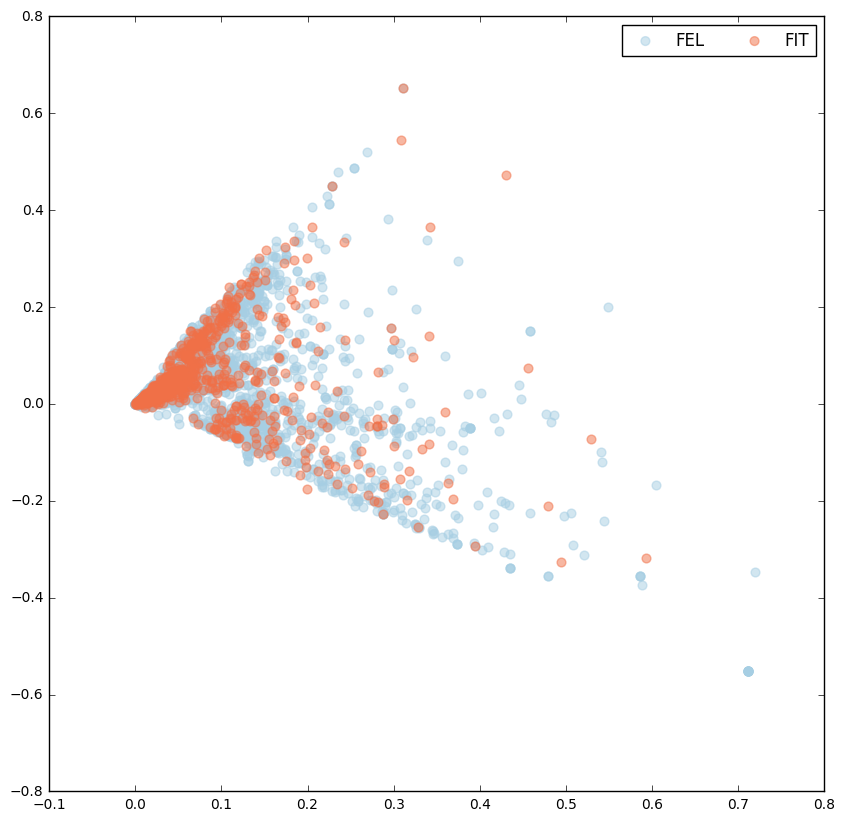

In [29]:
from collections import defaultdict
import pprint
import matplotlib.pyplot as plt

plot_axes(x=0, y=1)

x topic:
[('web', 0.48756491315473094), ('application', 0.43359596585136262), ('information', -0.42814681548921363), ('system', -0.35497662883909331), ('interface', 0.19626384181666451), ('tool', 0.12544500981748505), ('user', 0.12526416756102829), ('data', 0.11824288941485127), ('mobile', 0.10260267406681857), ('management', 0.087030971251552181)]

y topic:
[('system', 0.58565627795271535), ('information', 0.47620989245592288), ('management', 0.28832298288639446), ('web', 0.25447308693416193), ('application', 0.18289542029380487), ('project', 0.15979190237210339), ('support', 0.12384189806268962), ('implementation', 0.11185479016696184), ('design', 0.10608730432486833), ('interface', 0.095378097849436821)]
next


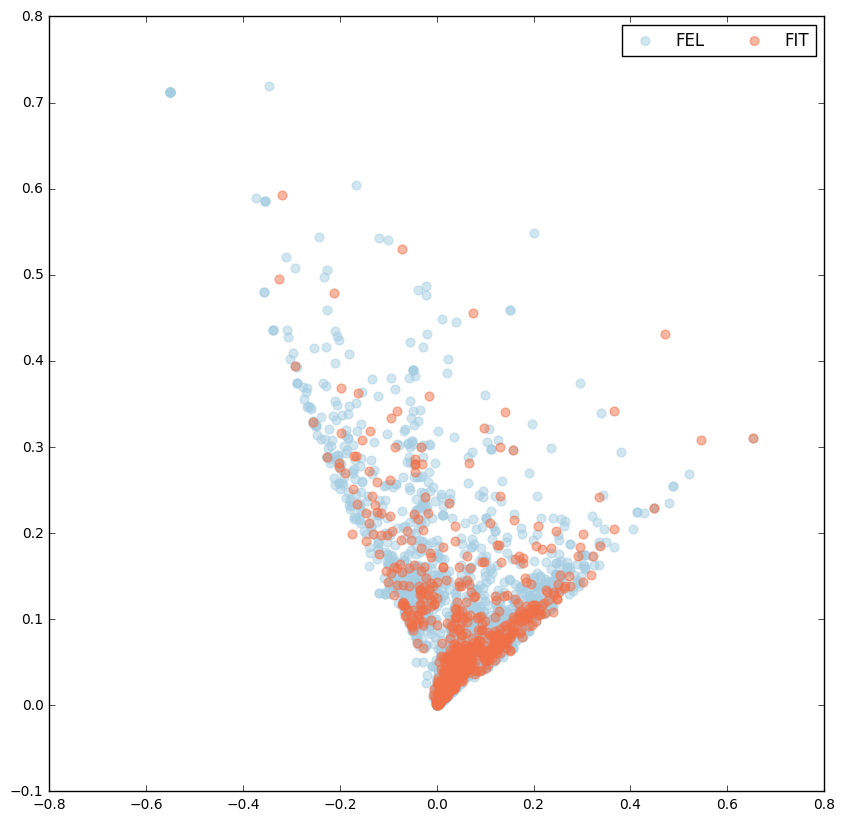

In [31]:
plot_axes(x=1, y=0) # same as above, but rotated